# Modeling with a pre-trained convolutional neural network

In this notebook, we use a pre-trained convolutional neural network (ConvNeXtXLarge) with additional, custom-created top layers to solve the problem of classifying animals in the photos of our dataset. The images are pre-loaded as tf.dataset objects, which have been previously separated into folders corresponding to the training, validation and test data sets.

The pre-trained network has its layers frozen (for time reasons, we did not employ fine-tuning after initial training). Additionally, hyperparameter search for the best network architecture and other training parameters is performed using hyperopt. The results of this search (and the resulting top layers of the trained networks) are saved using MLflow. Some training information and performance are displayed for the best model found during hyperparameter search.

As a final step, the model is re-trained with the entire dataset (training + validation + test) to get a better overall model that can be used in the drivendata.org challenge from which the dataset was procured.

In [1]:
import sys
import os
import gc
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #suppress tensorflow info/warning spam

# project-specific custom functions
# export the path to custom modules
sys.path.append("../functions")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import mlflow
import hyperopt

# import functions
from data_loading import load_data, get_label_name_from_filename
from mlflow_utils import start_mlflow_server, mlflow_train_keras_model
import mlflow_utils

RSEED = 42
sns.set_theme(style="white", palette=None)

In [2]:
#define convenience function for memory clearup, the lack of which could lead to OOM issues during hyperparameter search with large models

def clear_memory():
    tf.keras.backend.clear_session(free_memory=True) #clear tensorflow leftovers
    gc.collect() #call python garbage collection
    time.sleep(10) #garbage collection may take a few seconds
clear_memory()

#allow for flexible GPU memory allocation, also to help prevent memory issues
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
#specify data directories
dir_data_base_relative = "../data/dataset_split_categories/"  # the relative directory path to all data files
dir_data_train = dir_data_base_relative+"train"
dir_data_val = dir_data_base_relative+"validation"
dir_data_test = dir_data_base_relative+"test"

## Dataset prefetching

To ensure that our model does not learn to classify animals according to the image background (wildlife sightings are not distributed evenly between locations), we pre-split the dataset according to location (see the data_splitting notebook for more details). These pre-split data are now loaded into memory for faster access as tf.data.Dataset objects.

In [4]:
img_size_height, img_size_width = 224, 224
batch_size = 8

#define function to get tensorflow dataset objects
def get_dataset(data_dir, shuffle_flag):
    """Wrapper for tensorflow.keras.utils.image_dataset_from_directory()

    Args:
        data_dir (str): Directory to folder with subdirectories corresponding to the labels
        shuffle_flag (bool): Whether the data should be shuffled
    Returns:
        (tensorflow.data.Dataset): Prefetched Dataset object
    """
    return tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(img_size_height, img_size_width),
    batch_size=batch_size,
    shuffle=shuffle_flag,
    seed=RSEED,
    pad_to_aspect_ratio=True
)

dataset_train = get_dataset(data_dir=dir_data_train, shuffle_flag=True)
dataset_validation = get_dataset(data_dir=dir_data_val, shuffle_flag=False)
dataset_test = get_dataset(data_dir=dir_data_test, shuffle_flag=False)

Found 12955 files belonging to 8 classes.
Found 1647 files belonging to 8 classes.
Found 1886 files belonging to 8 classes.


## Class weights

The different classes of wildlife are not evenly distributed, which may cause our model to be biased. Therefore, we calculate new class weights that are inversely proportional to their frequency in the dataset.

In [5]:
y_true_train = []
for _, lbl in dataset_train:
    y_true_train.extend(lbl.numpy())
y_true_train = np.array(y_true_train)

class_sums = y_true_train.sum(axis=0)
total_sum = y_true_train.sum(axis=(0, 1))
inv_class_ratios = 1 / (class_sums / total_sum)
inv_class_ratios = inv_class_ratios / np.sum(inv_class_ratios)

class_weight_dict = {k:v for (k,v) in zip(range(8), inv_class_ratios)}

In [6]:
start_mlflow_server(experiment_name="ConvNeXtXLarge_experiment")

Tracking URI set to: file:///home/am/neuefische/Project__Wildlife_Images/mlflow
MLflow server started in the background


[2024-06-27 16:29:14 +0200] [67217] [INFO] Starting gunicorn 22.0.0
[2024-06-27 16:29:14 +0200] [67217] [INFO] Listening at: http://127.0.0.1:5000 (67217)
[2024-06-27 16:29:14 +0200] [67217] [INFO] Using worker: sync
[2024-06-27 16:29:14 +0200] [67218] [INFO] Booting worker with pid: 67218
[2024-06-27 16:29:14 +0200] [67219] [INFO] Booting worker with pid: 67219
[2024-06-27 16:29:14 +0200] [67220] [INFO] Booting worker with pid: 67220
[2024-06-27 16:29:14 +0200] [67222] [INFO] Booting worker with pid: 67222


MLflow server is running


## Hyperparameter search

The following section provides functions for creating a tensorflow.keras model as well as hyperparameter search with logging using MLflow. This second function is used with the MLflow wrapping functions provided in `mlflow_utils`.

In [9]:
def define_model(model_params):
    """Defines a Keras Sequential model for image class inference, with a pre-trained convolutional neural network as a base (ConvNeXtXLarge)

    Args:
        model_params (dict): A dictionary containing model hyperparameters to be varied during hyperparameter search
    Returns:
        model (tensorflow.keras.Sequential): The specified model (not compiled or fitted yet)
    """
    prebuilt_model = tf.keras.applications.ConvNeXtXLarge(include_top=False, pooling="max")
    prebuilt_model.trainable = False

    data_aug_layer = tf.keras.Sequential()
    data_aug_layer.add(tf.keras.layers.RandomRotation(factor=model_params["rotation_factor"]))
    data_aug_layer.add(tf.keras.layers.RandomFlip(mode="horizontal"))
    data_aug_layer.add(tf.keras.layers.RandomContrast(factor=model_params["contrast_factor"]))
    data_aug_layer.add(tf.keras.layers.RandomBrightness(factor=(model_params["brightness_factor_low"], model_params["brightness_factor_high"])))

    model_top = tf.keras.Sequential(name="model_top")

    for iStack in range(1, model_params["dense_stack_height"]+1):
        if model_params["batch_normalization"]:
            model_top.add(tf.keras.layers.BatchNormalization())
        model_top.add(tf.keras.layers.Dense(model_params["n_neurons"], name=f"Dense{iStack}", kernel_initializer="he_normal", activation="relu"))
        model_top.add(tf.keras.layers.Dropout(model_params["dropout_rate"], name=f"Dropout{iStack}"))

    model_top.add(tf.keras.layers.Dense(8, name="Final_output", activation="softmax"))

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(224, 224, 3)))
    model.add(data_aug_layer)
    model.add(prebuilt_model)
    model.add(model_top)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=model_params["learning_rate"], clipnorm=model_params["clipnorm"]),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
def model_training_function(search_params, components, train_data, valid_data):
    """Training function given over to to mlflow_train_keras_model() from mlflow_utils.

    Args:
        search_params (dict): A dictionary containing model hyperparameters to be varied during hyperparameter search
        components (dict): Contains a callback function for logging epoch-wise metrics in mlflow
        train_data (tensorflow.data.Dataset): Training data as a pre-fetched dataset object
        valid_data (tensorflow.data.Dataset): Validation data as a pre-fetched dataset object
    Returns:
        (dict): Dictionary for use by mlflow and hyperopt. Has to contain at least "loss" and "status". Other parameters are returned for further logging purposes.
    """

    clear_memory()
    
    #model architecture
    model = define_model(search_params)

    with mlflow.start_run(nested=True):

        #log params
        mlflow.log_params(search_params)

        #callback definition
        es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                        patience=5,
                                                        verbose=1,
                                                        start_from_epoch=0,
                                                        restore_best_weights=True)

        #model fitting
        try:
            history = model.fit(
                train_data,
                validation_data=valid_data,
                epochs=50,
                batch_size=batch_size,
                class_weight=search_params["class_weights"],
                callbacks=[components["mlflow_logger"], es_callback],
                verbose=2
            )
        except:
            return {"loss": None, "val_accuracy": None, "status": hyperopt.STATUS_FAIL}
        
        #evaluate the model
        eval_result = model.evaluate(valid_data, batch_size=batch_size)
        val_loss = eval_result[0]
        val_accuracy = eval_result[1]

        #log results
        mlflow.log_metric("final_val_loss", val_loss)
        mlflow.log_metric("training_epochs", len(history.history['loss']))
        mlflow.tensorflow.log_model(model.get_layer("model_top"), "model_top") #log only top part of the model to save hard disk memory

    return {"loss": val_loss, "val_accuracy": val_accuracy, "status": hyperopt.STATUS_OK, "model": model.get_layer("model_top"), "history": history} 



search_space = {
    "rotation_factor": hyperopt.hp.uniform("rotation_factor", 0.0, 0.5),
    "contrast_factor": hyperopt.hp.uniform("contrast_factor", 0.0, 1.0),
    "brightness_factor_low": hyperopt.hp.uniform("brightness_factor_low", -0.9, 0.0),
    "brightness_factor_high": hyperopt.hp.uniform("brightness_factor_high", 0.0, 0.9),
    "dense_stack_height": hyperopt.hp.uniformint("dense_stack_height", 1, 8),
    "batch_normalization": hyperopt.hp.choice("batch_normalization", (True, False)),
    "n_neurons": hyperopt.hp.uniformint("n_neurons", 16, 128),
    "dropout_rate": hyperopt.hp.uniform("dropout_rate", 0, 0.6),
    "learning_rate": hyperopt.hp.loguniform("learning_rate", -5, -2),
    "clipnorm": hyperopt.hp.choice("clipnorm", (None, 1.0)),
    "class_weights": hyperopt.hp.choice("class_weights", (None, class_weight_dict))
}

run = mlflow_train_keras_model(
    train_fn=model_training_function,
    train_data=dataset_train,
    valid_data=dataset_validation,
    search_space=search_space,
    n_evals=1,
    log_model=True
)

## Model evaluation

The following section shows some diagnostic information about the fitting process (of the best model found during hyperparameter search) and performance on the holdout data (confusion matrix).

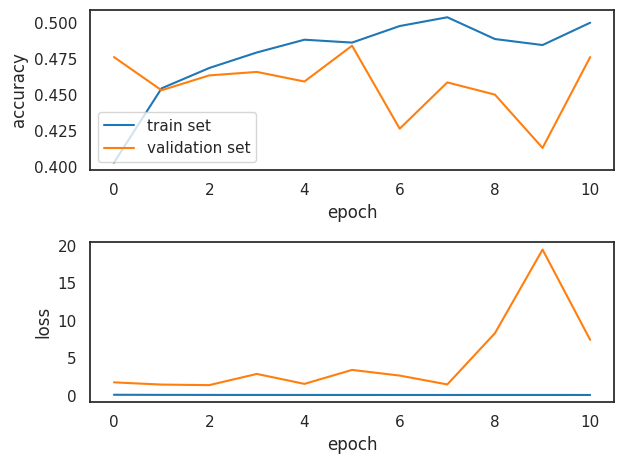

In [8]:
client = mlflow.tracking.MlflowClient()

fig, ax = plt.subplots(2, 1)

accuracies = [metric.value for metric in client.get_metric_history(run.info.run_id, "accuracy")]
val_accuracies = [metric.value for metric in client.get_metric_history(run.info.run_id, "val_accuracy")][1:]

losses = [metric.value for metric in client.get_metric_history(run.info.run_id, "loss")]
val_losses = [metric.value for metric in client.get_metric_history(run.info.run_id, "val_loss")]

ax[0].plot(accuracies, label='train set')
ax[0].plot(val_accuracies, label='validation set')
ax[0].set(xlabel='epoch',
          ylabel='accuracy')
ax[0].legend()

ax[1].plot(losses, label='train')
ax[1].plot(val_losses, label='val')
ax[1].set(xlabel='epoch',
          ylabel='loss')
fig.tight_layout()

When using complex pretrained models like ConvNeXtXLarge, model performance usually approaches final performance rather soon (in some cases within the first training epoch). The early stopping callback monitoring validation accuracy enables us to choose the best model before the model diverges (loss increasing dramatically) or overfits (validation accuracy decreases while training accuracy yet increases), ensuring good generalization

In [7]:
#re-load model top and attach the pre-trained model to get the whole model

#model_uri = f"runs:/{run.info.run_id}/model"
model_uri = f"runs:/707967c5485a4f338199a71ce39be5aa/model"
model_top = mlflow.tensorflow.load_model(model_uri)
model = tf.keras.Sequential()
model.add(tf.keras.applications.ConvNeXtXLarge(include_top=False, pooling="max"))
model.add(model_top)

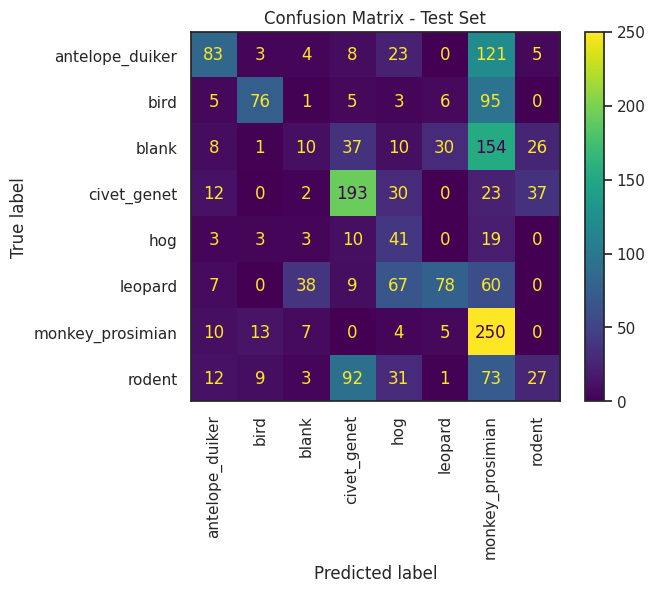

In [12]:
y_test_pred = model.predict(dataset_test, verbose=0)

#perform some data transformations to plot the confusion matrix
max_indices = np.argmax(y_test_pred, axis=1)
y_test_pred_ohe = np.zeros_like(y_test_pred)
y_test_pred_ohe[np.arange(y_test_pred.shape[0]), max_indices] = 1.0

y_true_test = []
for _, lbl in dataset_test:
    y_true_test.extend(lbl.numpy())
y_true_test = np.array(y_true_test)

cmd = ConfusionMatrixDisplay.from_predictions(np.argmax(y_true_test, axis=1), np.argmax(y_test_pred_ohe, axis=1), display_labels=dataset_test.class_names)
plt.title("Confusion Matrix - Test Set")
plt.xticks(rotation=90)
plt.show()

During our experiments, we noticed that with complex models the performance is generally decent. However, the model tends toward a single category when "unsure" (in this case, towards monkeys/prosimians).

## Re-training with full dataset

As a last step, the model gets fitted once more with the best hyperparameters, but with the entire dataset available to us. This should yield the best performance on yet another set of holdout data (the test data from the drivendata.org challenge), for which we have no labels available but can nonetheless evaluate on the challenge website. Finally, the model top gets saved on disk (for easier portability; the entire model can get recreated in the same fashion as above, when the confusion matrix was calculated). For time reasons, we did not perform fine-tuning (i.e., unfreezing the weights in the pre-trained model after initial training).

In [ ]:
#re-train model with best parameters on all data (for drivendata.org challenge)
dataset_train_val_test = dataset_train.concatenate(dataset_validation)
dataset_train_val_test = dataset_train_val_test.concatenate(dataset_test)
params = mlflow.get_run(run.info.run_id).data.params

#re-convert parameter data types manually (super annoying)
best_params = {}
for (key, val) in params.items():
    if key in ("rotation_factor", "contrast_factor", "brightness_factor_low", "brightness_factor_high", "dropout_rate", "learning_rate"):
        best_params[key] = float(val)
    elif key in ("dense_stack_height", "n_neurons"):
        best_params[key] = int(float(val))
    elif key == "batch_normalization":
        best_params[key] = bool(val)
    elif key == "clipnorm":
        if val == '0':
            best_params[key] = None
        else:
            best_params[key] = 1.0
    elif key == "class_weights":
        if val == '0':
            best_params[key] = None
        else:
            best_params[key] = class_weight_dict

#just the final fit, with early stopping being guided by accuracy instead of validation accuracy (which is not available anymore)
final_model = define_model(best_params)

history = final_model.fit(
    dataset_train_val_test,
    epochs=50,
    batch_size=batch_size,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                min_delta=0.001,
                                                patience=5,
                                                verbose=1,
                                                start_from_epoch=0,
                                                restore_best_weights=True)],
    class_weight=best_params["class_weights"],
    verbose=1
)

In [13]:
#save top layers of the model to disk
final_model.get_layer("model_top").save("../models/ConvNeXtXLarge_full_v1.keras")